In [1]:
#global imports
import os
import sys
import pandas as pd
import numpy as np
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
#local imports
sys.path.append('/Users/yangzhang/document/ds_projs')  
from myfunctions import WhosMissing, DisplayRMSEcvScores, rmse_cv

In [3]:
DATA_PATH = os.path.join('data')

In [4]:
def load_training_data(training_path=DATA_PATH):
    cvs_path = os.path.join(training_path, 'train.csv')
    return pd.read_csv(cvs_path)

In [5]:
def load_predicting_data(predicting_path=DATA_PATH):
    cvs_path = os.path.join(predicting_path, 'test.csv')
    return pd.read_csv(cvs_path)

In [6]:
train_preview = load_training_data()

In [7]:
WhosMissing(train_preview)

This data set has 19 features with missing values.


[None,
               Total   Percent
 PoolQC         1453  0.995205
 MiscFeature    1406  0.963014
 Alley          1369  0.937671
 Fence          1179  0.807534
 FireplaceQu     690  0.472603
 LotFrontage     259  0.177397
 GarageCond       81  0.055479
 GarageType       81  0.055479
 GarageYrBlt      81  0.055479
 GarageFinish     81  0.055479
 GarageQual       81  0.055479
 BsmtExposure     38  0.026027
 BsmtFinType2     38  0.026027
 BsmtFinType1     37  0.025342
 BsmtCond         37  0.025342
 BsmtQual         37  0.025342
 MasVnrArea        8  0.005479
 MasVnrType        8  0.005479
 Electrical        1  0.000685]

In [8]:
test_preview = load_predicting_data()

In [9]:
WhosMissing(test_preview)

This data set has 33 features with missing values.


[None,
               Total   Percent
 PoolQC         1456  0.997944
 MiscFeature    1408  0.965045
 Alley          1352  0.926662
 Fence          1169  0.801234
 FireplaceQu     730  0.500343
 LotFrontage     227  0.155586
 GarageCond       78  0.053461
 GarageQual       78  0.053461
 GarageYrBlt      78  0.053461
 GarageFinish     78  0.053461
 GarageType       76  0.052090
 BsmtCond         45  0.030843
 BsmtQual         44  0.030158
 BsmtExposure     44  0.030158
 BsmtFinType1     42  0.028787
 BsmtFinType2     42  0.028787
 MasVnrType       16  0.010966
 MasVnrArea       15  0.010281
 MSZoning          4  0.002742
 BsmtHalfBath      2  0.001371
 Utilities         2  0.001371
 Functional        2  0.001371
 BsmtFullBath      2  0.001371
 BsmtFinSF2        1  0.000685
 BsmtFinSF1        1  0.000685
 Exterior2nd       1  0.000685
 BsmtUnfSF         1  0.000685
 TotalBsmtSF       1  0.000685
 SaleType          1  0.000685
 Exterior1st       1  0.000685
 KitchenQual       1  0.000685
 

# Prepare data for ML

## Feature Imputation

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin#, RegressorMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder#, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline#, FeatureUnion
from scipy.stats import skew
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin

In [11]:
class FeatureImputer(BaseEstimator, TransformerMixin):
    """
    This class fills in missing values for both test and train data sets.
    """
    def __init__(self, fill_missvals=True):
        self.fill_missvals = fill_missvals
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.fill_missvals:
            X['PoolQC'] = X['PoolQC'].fillna('None')
            X['MiscFeature'] = X['MiscFeature'].fillna('None')
            X['Alley'] = X['Alley'].fillna('None')
            X['Fence'] = X['Fence'].fillna('None')
            X['FireplaceQu'] = X['FireplaceQu'].fillna('None')
            X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
            for col in ('GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtExposure', 'GarageYrBlt',
                        'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtQual', 'MasVnrType'):
                X[col] = X[col].fillna('None')   
            X['Electrical'] = X['Electrical'].fillna(X['Electrical'].mode()[0])
            
            X['MSZoning'] = X['MSZoning'].fillna(X['MSZoning'].mode()[0])
            X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])
            X['KitchenQual'] = X['KitchenQual'].fillna(X['KitchenQual'].mode()[0])
            X['Exterior1st'] = X['Exterior1st'].fillna(X[X['HouseStyle'] == '1Story'].Exterior1st.mode()[0])
            X['Exterior2nd'] = X['Exterior2nd'].fillna(X[X['HouseStyle'] == '1Story'].Exterior2nd.mode()[0])
            X['Utilities'] = X['Utilities'].fillna(X[X['HouseStyle'] == '1Story'].Utilities.mode()[0])
            X['GarageCars'] = X['GarageCars'].fillna(X[X['GarageType'] == 'Detchd'].GarageCars.mode()[0])
            X['GarageArea'] = X['GarageArea'].fillna(X[X['GarageType'] == 'Detchd'].GarageArea.mean())
            X["Functional"] = X["Functional"].fillna("Typ")
            
            for col in ('MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
                X[col] = X[col].fillna(0)

            #X['GarageYrBlt'] = X['GarageYrBlt'].astype(str)
            X['MSSubClass'] = X['MSSubClass'].astype(str)   
                   
        return X

In [12]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Add a few new features.
    """
    def __init__(self, additional=1):
        self.additional = additional
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.additional == 1:
            X['HouseAge'] = X['YrSold'] - X['YearBuilt']
            X['BathperRoom'] = (X['FullBath'] + X['HalfBath']*2) / X['TotRmsAbvGrd']
            X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
            X['TotalArea'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF'] + X['GarageArea']
            X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
        else:
            X['HouseAge'] = X['YrSold'] - X['YearBuilt']
            X['BathperRoom'] = (X['FullBath'] + X['HalfBath']*2) / X['TotRmsAbvGrd']
            X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
            X['TotalArea'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF'] + X['GarageArea']
            X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
        
        return X     

In [13]:
class DropCols(BaseEstimator, TransformerMixin):
    def __init__(self, remove_cols=True):
        self.remove_cols = remove_cols
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.remove_cols:
            del X['MoSold']
            del X['GarageYrBlt']
            del X['YearBuilt']
            del X['YearRemodAdd']
            del X['YrSold']
            del X['PoolQC']
            del X['MiscFeature']
            #del X['MiscVal']
            #del X['Utilities']     
            #del X['RoofMatl']
            #del X['LandContour']
            #del X['Street']
            #del X['Condition1']
            #del X['Condition2']
            #del X['LotConfig']
            #del X['PoolArea']
            #del X['MSSubClass']
            #del X['3SsnPorch']
            #del X['FireplaceQu']
            #del X['LowQualFinSF']
            #del X['OverallCond']
            #del X['BsmtHalfBath']
            #del X['BsmtFinType2']
            #del X['LandSlope']
        return X

In [14]:
train_preview.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [15]:
train_preview.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Numerical transformer

In [16]:
class NumericTransformer(BaseEstimator, TransformerMixin):
    """
    This takes care of the skewness.
    """
    def __init__(self, skew=0.75):
        self.skew = skew
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #X['MSSubClass'] = X['MSSubClass'].apply(str)
        numerical_attribs = X.select_dtypes(exclude='object').columns
        X_numeric = X[numerical_attribs]
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        #X = pd.get_dummies(X)
        
        return X

In [17]:
num_transformer = Pipeline([
    ('imputer', NumericTransformer(skew=0.5))
])

## Categorical transformer

In [18]:
# One-hot encode categorical values
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=None)),
    ('onehot', OneHotEncoder(handle_unknown='error'))])

In [19]:
## put together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, selector(dtype_exclude='object')),
        ('cat', cat_transformer, selector(dtype_include='object'))])

In [20]:
#credit: https://stackoverflow.com/questions/57528350/can-you-consistently-keep-track-of-column-labels-using-sklearns-transformer-api

def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names()]
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in

def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features

## Complete pipeline

In [21]:
preprocessing = Pipeline([
    ('missing_val', FeatureImputer()),
    ('new_features', FeatureEngineer()),
    ('drop_cols', DropCols()),
    ('preprocessor', preprocessor),
])

In [46]:
from sklearn import set_config
set_config(display='diagram')
preprocessing

Pipeline(steps=[('missing_val', FeatureImputer()),
                ('new_features', FeatureEngineer()), ('drop_cols', DropCols()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   NumericTransformer(skew=0.5))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe4d126b3a0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe4d126b6d0>)]))])

# Model training

## getting data ready

In [23]:
train_preview = load_training_data()
train_preview['MSSubClass'] = train_preview['MSSubClass'].apply(str)
train_X = train_preview.drop(['Id', 'SalePrice'], axis=1)
train_X.shape

(1460, 79)

In [24]:
train_y = train_preview['SalePrice']
train_y.shape

(1460,)

In [25]:
train_X_ready = preprocessing.fit_transform(train_X)

In [26]:
train_X_ready

<1460x307 sparse matrix of type '<class 'numpy.float64'>'
	with 94523 stored elements in Compressed Sparse Row format>

In [27]:
train_X_ready = pd.DataFrame(train_X_ready.toarray(),
             columns=get_ct_feature_names(preprocessor))

In [28]:
train_X_ready.head(5)

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,HouseAge,BathperRoom,TotalSF,TotalArea,TotalPorch,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Fi

# Base models

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

## Regression

### linear regression

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
lin_reg = LinearRegression()
lin_reg.fit(train_X_ready, train_y)

LinearRegression()

In [32]:
predictions = lin_reg.predict(train_X_ready)
lin_mse = mean_squared_error(train_y, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

22272.41924795612

In [33]:
DisplayRMSEcvScores(lin_reg, train_X_ready, train_y)

Scores: [23093.84980489 27425.84153113 26572.02479367 39741.12359546
 34794.1355744  37928.33336954 26944.77687298 25173.54813544
 51390.47185421 25355.90615372]
Mean: 31842.001
Standard deviation: 8512.480


### Decision tree

In [35]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_X_ready, train_y)

predictions = tree_reg.predict(train_X_ready)
tree_mse = mean_squared_error(train_y, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

157.29955716699112

In [37]:
DisplayRMSEcvScores(tree_reg, train_X_ready, train_y)

Scores: [37159.92399096 39200.55444184 36552.87681012 41757.39874701
 38771.11165272 42642.83870791 32015.20928574 32247.67951936
 41423.04037296 41203.02550959]
Mean: 38297.366
Standard deviation: 3612.604


### Random forests

In [39]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(train_X_ready, train_y)

predictions = forest_reg.predict(train_X_ready)
forest_mse = mean_squared_error(train_y, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

10884.674715342466

In [40]:
DisplayRMSEcvScores(forest_reg, train_X_ready, train_y)

Scores: [25235.01562542 26604.97603898 29179.90870226 39255.87173388
 32964.89988704 23789.63339676 24566.76731989 23738.36049398
 37610.84403061 23516.6659217 ]
Mean: 28646.294
Standard deviation: 5641.771


In [45]:
## save model result
import joblib

joblib.dump(lin_reg, './models/base_LR.pkl')
joblib.dump(tree_reg, './models/base_DT.pkl')
joblib.dump(forest_reg, './models/base_RF.pkl')

['./models/base_RF.pkl']

### Lasso regression

In [48]:
from sklearn.linear_model import Lasso

In [112]:
llr = Lasso(alpha=130, fit_intercept=True, max_iter=10000, normalize=False, positive=False, precompute=False, random_state=None)

In [113]:
llr.fit(train_X_ready, train_y)

Lasso(alpha=130, max_iter=10000)

In [114]:
DisplayRMSEcvScores(llr, train_X_ready, train_y)

Scores: [20355.54283488 24008.16932471 23530.14811999 37298.90571212
 34733.93989186 28988.64523497 25792.10899005 23651.56004464
 47114.49416581 24044.78015869]
Mean: 28951.829
Standard deviation: 7892.253


In [105]:
FI_lasso = pd.DataFrame({'Feature Importance': llr.coef_},
                       index=train_X_ready.columns)

<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

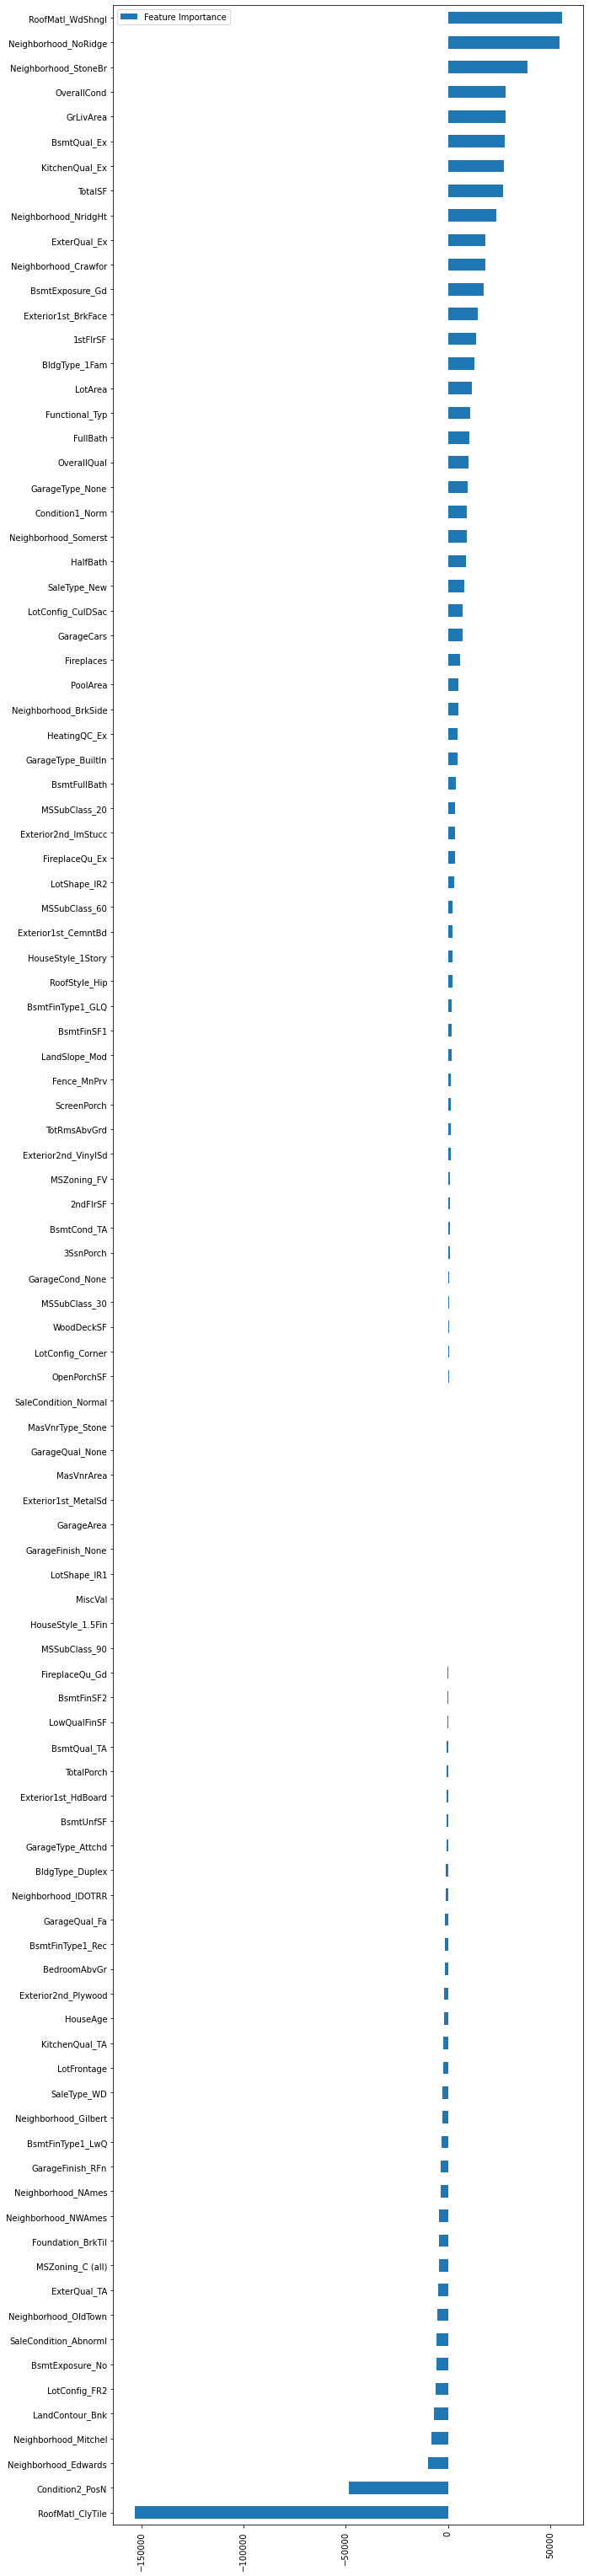

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline

FI_lasso[FI_lasso['Feature Importance'] != 0].sort_values('Feature Importance').plot(kind='barh', figsize=(10,55))
plt.xticks(rotation=90)
plt.ylabel
#plt.show

## Correlation matrix

In [100]:
forcorr = pd.concat([view, y], axis=1)
corr_matrix = forcorr.corr()
pd.options.display.max_rows = 2000
with open('corr.txt', 'w') as f:
    print(corr_matrix['SalePrice'].sort_values(ascending=False), 'corr.txt', file=f)

In [ ]:
scaler = RobustScaler()

In [ ]:
dfFinal = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [ ]:
dfFinal.head()

In [ ]:
# define cross validation 
from sklearn.model_selection import cross_val_score, StratifiedKFold
def rmse_cv(model,X,y):
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)
    #the MSE scores returned is always negative
    rmse = np.sqrt(-scores) 
    return rmse # the higher the better

In [ ]:
#HYPERPARAMS NOT optimized
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          BayesianRidge(),
          SGDRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          SVR(),
          KernelRidge(),
          ExtraTreesRegressor()]
names = ["Linear Rregression", "Ridge", "Lasso", "Elastic Net", "Bayesian Ridge", "SGD",
         "RF", "GBR", "SVR", "Ker","Extra"]

In [ ]:
# Run the models and compare
from operator import itemgetter
ModScores = {}

for name, model in zip(names, models):
    score = rmse_cv(model, dfFinal, train_y_final)
    ModScores[name] = score.mean()
    print("{}: {:.6f}".format(name,score.mean()))

print("trainFinal ", dfFinal.shape)
print("="*80)
for key, value in sorted(ModScores.items(), key = itemgetter(1), reverse = False):
    print(key, value)

In [ ]:
class grid():
    def __init__(self, model):
        self.model = model
        
    def grid_get(self, X, y, param_grid):
        grid_search = GridSearchCV(self.model, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']])

In [ ]:
def PlotLearningCurve(estimator, title, X, y, ylim=None, cv=None,
                     n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlable('Training examples')
    plt.ylabel('Error')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = 1-np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = 1-np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross Validation score')
    
    plt.legend(loc='best')
    return plt

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

# Model selection

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]
for classifier in classifiers:
    pipe = make_pipeline(col_transformer, classifier)
    pipe.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_val, y_val))